In [ ]:
from google.colab import drive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from fastai.vision.all import *

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Talkapalooza - TL BL SS 23

# Leveraging FastAI's pretrained models:

Despite Fastaudio hiccups, I need to move ahead with FastAI to obtain first results.
Instead of relying on Fastaudio for loading and transforming audio files, I generated spectrograms from the Lingualibre dataset.

Using the CSV cross-referencing Lingualibre recordings and Wordbank words, including number of recordings per word. This information also allows for the creation of filters, so to speak, which have proven necessary as per our experiences.

Those that are not in the CSV:

*   skip
*   add to "others" category?

#### Three recording filter

In [ ]:
src = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms'

In [ ]:
image_data = get_files(src, extensions='.png')

In [ ]:
filtered_wordbank_df = pd.read_csv('/content/drive/MyDrive/talkapalooza/data/wordbank_crossref_filt3.csv')

In [ ]:
filtered_words = filtered_wordbank_df["word"]

In [ ]:
list(filtered_words[:10])

['a', 'about', 'after', 'all', 'am', 'an', 'and', 'animal', 'any', 'are']

In [ ]:
filtered_paths = list()

In [ ]:
for p in image_data:
  if p.name.split('--')[0] in list(filtered_words):
    filtered_paths.append(p)

Filtering out words that have less than three recordings, 389 words from the dataset were dropped.

In [ ]:
len(image_data) - len(filtered_paths)

389

In [ ]:
from fastcore.utils import gt

In [ ]:
filtered_image_data = L(filtered_paths)

In [ ]:
filtered_image_data

(#816) [Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/ear--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/so--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/see--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/think--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/big--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/any--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/fish--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/there--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/when--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/here--Vivekteraiyavt.png')...]

In [ ]:
import shutil

In [ ]:
for p in filtered_image_data:
  p_src = p
  p_dst = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/' + p.name
  shutil.copy(p_src, p_dst)

In [ ]:
src_filtered = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered'

In [ ]:
Path(src_filtered).ls()

(#816) [Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/ear--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/so--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/see--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/think--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/big--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/any--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/fish--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/there--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/when--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filtered/here--Vivekteraiyavt.png')...]

## Training with words that have at least three recordings

In [ ]:
words = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)--.+.png$'), 'name'),
                 item_tfms=Resize(300),
                 batch_tfms=aug_transforms(size=224, min_scale=0.85, do_flip = False, max_rotate=0))
dls = words.dataloaders(src_filtered)

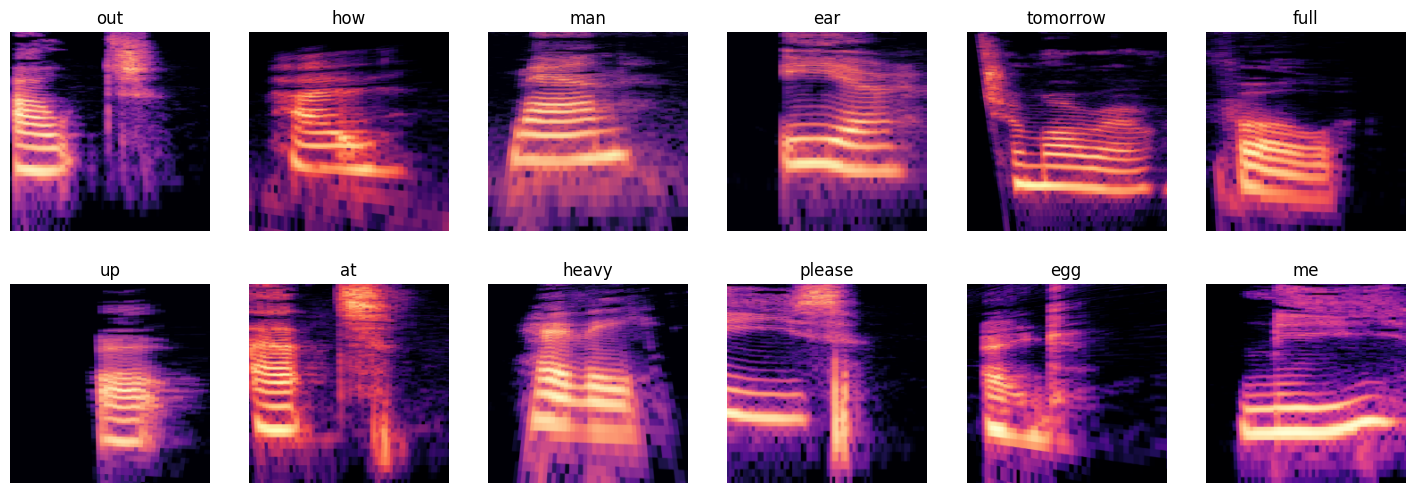

In [ ]:
dls.train.show_batch(max_n=12, nrows=2)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,7.148468,6.022514,0.987730,00:09


epoch,train_loss,valid_loss,error_rate,time
0,6.808220,5.707068,0.987730,00:08
1,6.488250,5.643475,0.981595,00:12
2,6.148468,5.674526,0.993865,00:11


Atrocious accuracy less than 1%.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

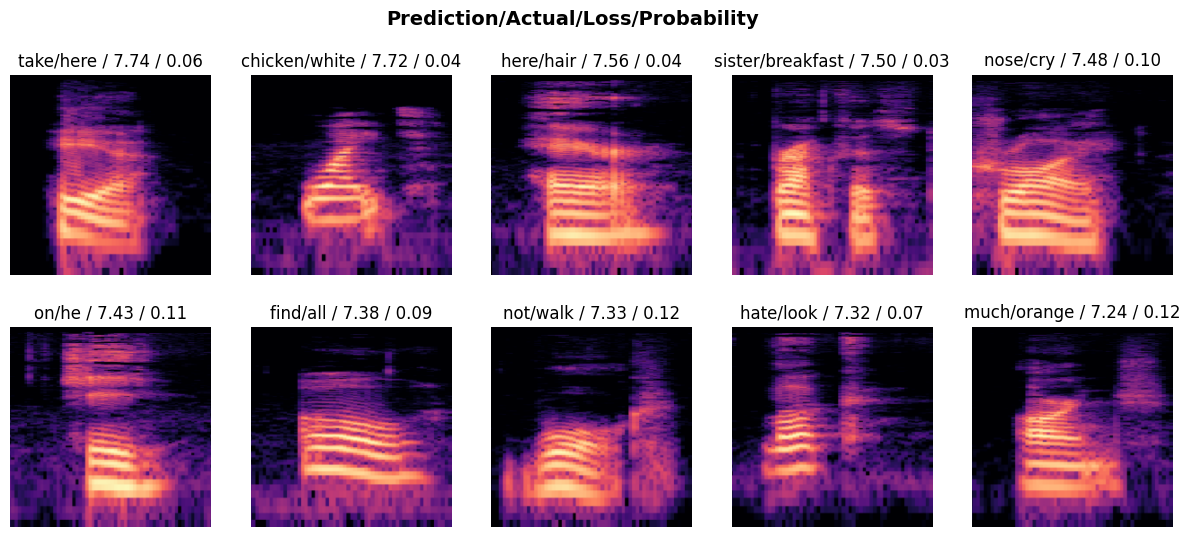

In [ ]:
interp.plot_top_losses(10, nrows=2)

### Trying different pretrained models

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,7.192500,6.003738,0.993865,00:09


epoch,train_loss,valid_loss,error_rate,time
0,6.681146,5.801507,0.987730,00:08
1,6.358017,5.728304,0.993865,00:09
2,6.102942,5.672005,0.981595,00:09


In [ ]:
learn = vision_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 226MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,7.190537,6.143087,0.987730,00:12


epoch,train_loss,valid_loss,error_rate,time
0,6.135591,6.012720,0.993865,00:14
1,5.747106,6.038786,0.981595,00:14
2,5.293352,5.874293,0.993865,00:14


In [ ]:
learn = vision_learner(dls, squeezenet1_0, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 56.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,7.133004,6.197472,1.000000,00:09


epoch,train_loss,valid_loss,error_rate,time
0,6.645965,5.754967,0.993865,00:07
1,6.497597,5.903928,0.987730,00:10
2,6.291774,5.834415,1.000000,00:09


In [ ]:
learn = vision_learner(dls, vgg19_bn, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:05<00:00, 102MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,7.100792,5.357295,0.993865,00:13


epoch,train_loss,valid_loss,error_rate,time
0,6.730321,5.470080,0.993865,00:15
1,6.479776,5.554864,0.981595,00:15
2,6.206101,5.550345,0.987730,00:15


The differences with this data and across three epochs are negligible.

### Modifying transforms

In [ ]:
words = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)--.+.png$'), 'name'),
                 item_tfms=Resize(300),
                 batch_tfms=aug_transforms(size=224, min_scale=1, do_flip = False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0, p_affine=0, p_lighting=1))
dls = words.dataloaders(src_filtered)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,7.214091,6.340239,0.987730,00:10


epoch,train_loss,valid_loss,error_rate,time
0,6.670695,5.892597,0.993865,00:13
1,5.957854,5.722867,0.993865,00:10
2,5.371896,5.695338,0.993865,00:09


So far, it has been difficult to see improvements in the training by modifying the architecture or model parameters. It's possible that the current training data itself is still flawed.

## Further reducing training data by limiting to words with at least 5 recordings

In [ ]:
import shutil
from fastcore.utils import gt

Only 53 words remain:

In [ ]:
len(filtered_wordbank_df[filtered_wordbank_df["count"] >= 5])

53

In [ ]:
filtered_words_5 = filtered_wordbank_df[filtered_wordbank_df["count"] >= 5]["word"]

In [ ]:
filtered_paths_5 = list()

In [ ]:
for p in image_data:
  if p.name.split('--')[0] in list(filtered_words_5):
    filtered_paths_5.append(p)

In [ ]:
for p in filtered_image_data:
  p_src = p
  p_dst = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/' + p.name
  shutil.copy(p_src, p_dst)

In [ ]:
src_filter5 = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5'

In [ ]:
Path(src_filter5).ls()

(#345) [Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/big--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/fish--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/there--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/when--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/here--Vivekteraiyavt.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/he--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/not--SpringProof.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/night--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/this--Exilexi.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_filter5/some--Opsylac.png')...]

### Training with words that have at least five recordings

In [ ]:
words = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)--.+.png$'), 'name'),
                 item_tfms=Resize(300),
                 batch_tfms=aug_transforms(size=224, min_scale=0.85, do_flip = False, max_rotate=0))
dls = words.dataloaders(src_filter5)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,5.650174,5.690018,0.985507,00:04


epoch,train_loss,valid_loss,error_rate,time
0,5.495042,5.078794,0.971014,00:04
1,5.288824,4.960822,0.985507,00:05
2,4.973641,4.784912,0.985507,00:04


In [ ]:
words = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)--.+.png$'), 'name'),
                 item_tfms=Resize(300),
                 batch_tfms=aug_transforms(size=224, min_scale=0.85, do_flip = False, max_rotate=0))
dls = words.dataloaders(src)

Still little improvements.

## Optimising LR

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,5.657626,6.363262,1.000000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,5.385656,5.141788,0.985507,00:07
1,5.109671,4.805141,0.971014,00:04
2,4.876009,4.659915,0.956522,00:06


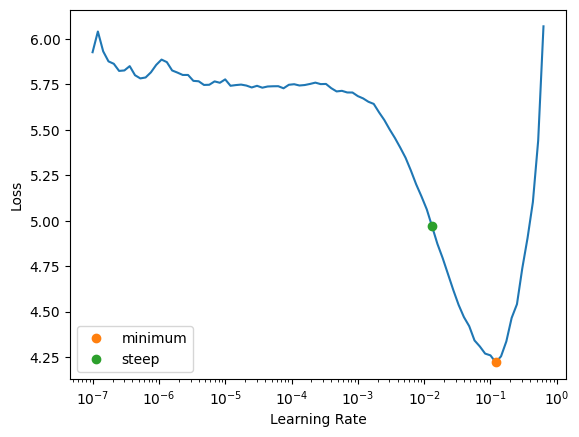

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 1.32e-02


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3, base_lr=lr_steep)

epoch,train_loss,valid_loss,error_rate,time
0,5.698592,6.076056,0.985507,00:05


epoch,train_loss,valid_loss,error_rate,time
0,4.332901,5.525618,0.985507,00:04
1,3.900000,6.364911,0.942029,00:04
2,3.337640,5.143716,0.927536,00:05


For the first time, a somewhat drastic change was observed. Previous iterations were obviously using a badly adjusted learning rate.

## Desperate measures: Increasing the epochs drastically

### Regular

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,5.891287,6.235443,0.971014,00:04


epoch,train_loss,valid_loss,error_rate,time
0,5.667248,5.074749,0.985507,00:05
1,5.370970,4.768720,0.985507,00:04
2,5.294453,4.650812,0.971014,00:04
3,5.121829,4.559843,0.985507,00:05
4,5.007818,4.467882,0.971014,00:04
5,4.855654,4.388194,0.956522,00:04
6,4.659584,4.345731,0.927536,00:05
7,4.420643,4.317446,0.956522,00:04
8,4.166553,4.241134,0.913043,00:04
9,3.895518,4.102433,0.927536,00:05


### Optimised LR

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(20, base_lr=lr_steep)

epoch,train_loss,valid_loss,error_rate,time
0,5.697388,6.452587,0.971014,00:03


epoch,train_loss,valid_loss,error_rate,time
0,4.579838,5.274814,1.000000,00:04
1,4.064710,4.775942,0.956522,00:05
2,3.601683,4.653012,0.956522,00:04
3,3.086535,4.853755,0.927536,00:04
4,2.691759,5.205808,0.942029,00:05
5,2.329486,5.430307,0.840580,00:04
6,2.038960,5.135411,0.840580,00:04
7,1.792919,5.038275,0.840580,00:05
8,1.586545,4.772933,0.797101,00:04
9,1.399852,4.803997,0.768116,00:04


## Preliminary test predicting test audio using my own voice

In [ ]:
print(*list(filtered_words_5)[::2], sep=", ")

all, animal, big, bottle, child, do, egg, fish, foot, grass, he, here, leg, man, meat, night, not, on, some, stick, that, they, tongue, we, when, who, you


In [ ]:
print(f"Night predicts 'night': {learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[0] == 'night'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[0]}'")
print(f"Fish predicts 'fish': {learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')[0] == 'fish'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')[0]}'")
print(f"Chicken predicts 'chicken': {learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')[0] == 'chicken'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')[0]}'")
print(f"Tongue predicts 'tongue': {learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')[0] == 'tongue'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')[0]}'")
print(f"Grass predicts 'grass': {learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')[0] == 'grass'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')[0]}'")
print(f"Flower predicts 'flower': {learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')[0] == 'flower'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')[0]}'")

Night predicts 'night': True. Predicted: 'night'


Fish predicts 'fish': False. Predicted: 'this'


Chicken predicts 'chicken': True. Predicted: 'chicken'


Tongue predicts 'tongue': True. Predicted: 'tongue'


Grass predicts 'grass': False. Predicted: 'tongue'


Flower predicts 'flower': False. Predicted: 'man'


## Creating an "others" category

To still make use of remaining recordings, can the model maybe be improved by training it with an amalgamation of recordings that will all be sorted into an "others" category?

labelled_spectrograms_with_noise

In [ ]:
for p in image_data:
  if p.name.split('--')[0] in list(filtered_words_5):
    filtered_paths_5.append(p)

In [ ]:
image_data = get_files(src, extensions='.png')

In [ ]:
image_data

(#1205) [Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/ear--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/so--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/see--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/think--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/washing machine--Jjamesryan.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/big--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/telephone--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/cover--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/blow--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/pencil--Nattes-à-chat.png')...]

In [ ]:
image_data[0].name.replace('--', '__')

'ear__Lirazelf.png'

In [ ]:
for p in image_data:
  p_src = p
  if p not in filtered_image_data:
    p_dst = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/' + 'others--' + p.name.replace('--', '__')
  else:
    p_dst = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/' + p.name
  shutil.copy(p_src, p_dst)

In [ ]:
src_with_noise = '/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise'
Path(src_with_noise).ls()

(#1205) [Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--ear__Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--so__Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--see__Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--think__Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--washing machine__Jjamesryan.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/big--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--telephone__Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--cover__Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms_with_noise/others--blow__Nattes-à-chat.png'),Path('/content/drive/M

In [ ]:
Path(src).ls()

(#1205) [Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/ear--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/so--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/see--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/think--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/washing machine--Jjamesryan.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/big--Lirazelf.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/telephone--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/cover--Back-ache.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/blow--Nattes-à-chat.png'),Path('/content/drive/MyDrive/talkapalooza/labelled_spectrograms/pencil--Nattes-à-chat.png')...]

In [ ]:
words = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)--.+.png$'), 'name'),
                 item_tfms=False,
                 batch_tfms=aug_transforms(size=350, min_scale=0.95, do_flip = False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0, p_affine=1, p_lighting=1))
dls = words.dataloaders(src)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


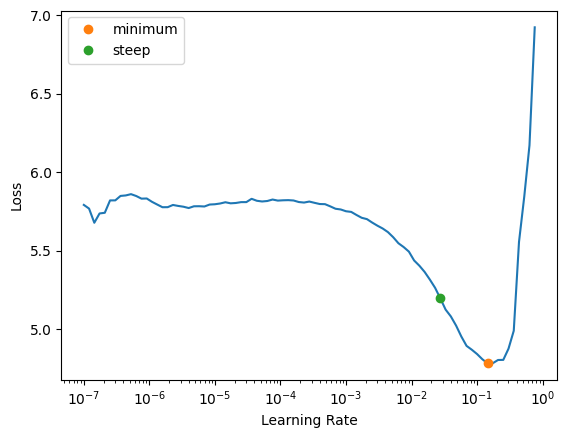

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
lr_steep

0.02754228748381138

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3, base_lr=lr_steep)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,4.764069,4.707083,0.688797,00:13


epoch,train_loss,valid_loss,error_rate,time
0,2.684632,5.442774,0.336100,00:14
1,2.350949,6.060220,0.410788,00:16
2,2.079798,2.235317,0.336100,00:14


Results seem much better, however this is probably just thanks to the fact that a lot of values can be matched to the others category, no matter if they would be correct or not.

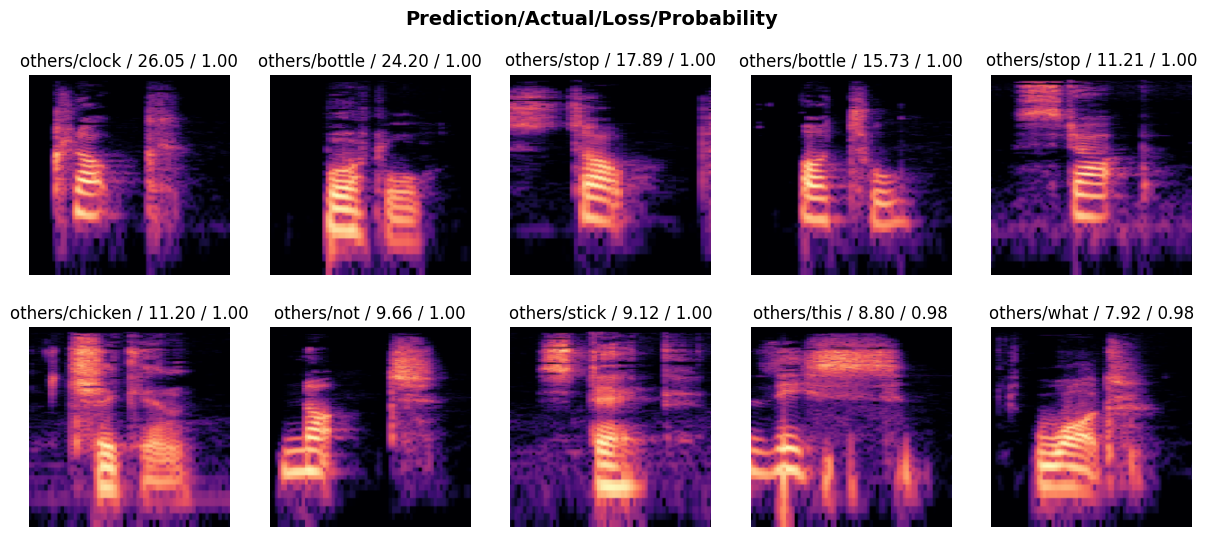

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(10, nrows=2)

In [ ]:
print(f"Night predicts 'night': {learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[0] == 'night'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/night.png')[0]}'")
print(f"Fish predicts 'fish': {learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')[0] == 'fish'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/fish.png')[0]}'")
print(f"Chicken predicts 'chicken': {learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')[0] == 'chicken'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/chicken.png')[0]}'")
print(f"Tongue predicts 'tongue': {learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')[0] == 'tongue'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/tongue.png')[0]}'")
print(f"Grass predicts 'grass': {learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')[0] == 'grass'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/grass.png')[0]}'")
print(f"Flower predicts 'flower': {learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')[0] == 'flower'}. Predicted: '{learn.predict('./drive/MyDrive/talkapalooza/test_data/flower.png')[0]}'")

Night predicts 'night': False. Predicted: 'others'


Fish predicts 'fish': False. Predicted: 'others'


Chicken predicts 'chicken': False. Predicted: 'others'


Tongue predicts 'tongue': False. Predicted: 'others'


Grass predicts 'grass': False. Predicted: 'others'


Flower predicts 'flower': False. Predicted: 'others'


Clearly worse because in fact now everything just gets sorted into "others". Let's see if running more epochs helps (previous try was after running 20 epochs).